In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Part 1: Data Exploration

In [26]:
df = pd.read_csv('Assignment5_Data.csv')
df.head()

,x1,x2
0,-2.505828,4.231421
1,-2.015031,2.577902
2,-0.778732,3.736001
3,-1.525042,2.950457
4,-0.619687,2.703252


In [27]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

print(scaled_df.head())

         x1        x2
0 -1.371927 -0.451673
1 -1.232381 -1.558762
2 -0.880869 -0.783374
3 -1.093064 -1.309323
4 -0.835648 -1.474836


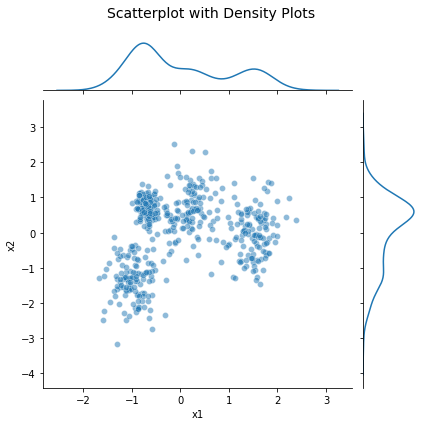

In [28]:
g = sns.JointGrid(data=scaled_df, x=scaled_df.columns[0], y=scaled_df.columns[1], height=6)
g.plot_joint(sns.scatterplot, alpha=0.5)
g.plot_marginals(sns.kdeplot)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Scatterplot with Density Plots", fontsize=14)
plt.show()

a) estimated number of clusters - 4
b) the cluster densities are different, the top left cluster is much more dense than the other 3, which are not as dense and have more low-density areas
c) there are regions of overlap in the low-density areas of these clusters, since they're all fairly close together, there are areas of overlap

# Part 2: K-Means Clustering

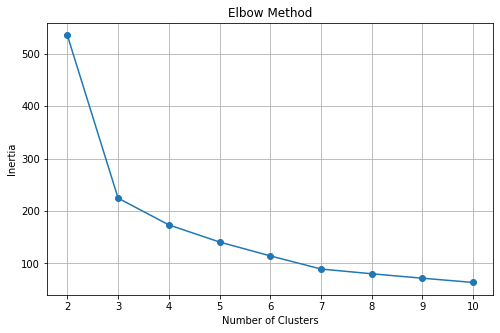

In [29]:
k_values = range(2, 11)

inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# elbow method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid()
plt.show()

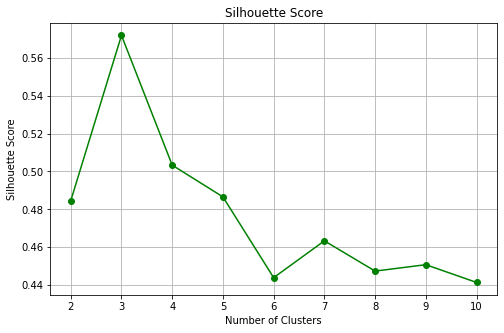

In [30]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_df, labels))

# silhouette score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.grid()
plt.show()

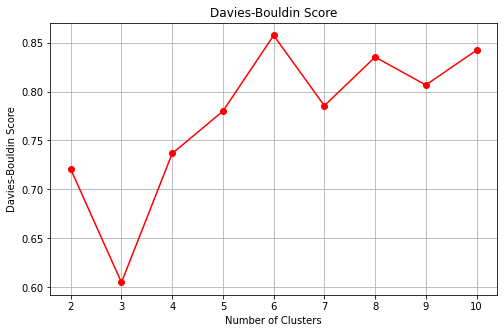

In [31]:
db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(scaled_df, labels))

# Davies-Bouldin score
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o', color='red')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score")
plt.grid()
plt.show()

1. Elbow Method: 3 clusters (point where it decreases sharply and levels off)
2. Silhouette Score: 3 clusters (highest score)
3. David-Bouldin Score: 3 clusters (lowest score)

Based on the above results, the optimum number of clusters is 3

In [32]:
optimal_k = 3
best_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
best_kmeans.fit(scaled_df)

scaled_df['KMeans_Labels'] = best_kmeans.labels_

print(scaled_df.head())

         x1        x2  KMeans_Labels
0 -1.371927 -0.451673              0
1 -1.232381 -1.558762              0
2 -0.880869 -0.783374              0
3 -1.093064 -1.309323              0
4 -0.835648 -1.474836              0


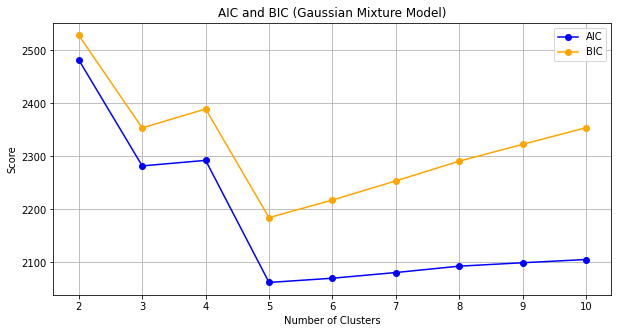

In [33]:
aic_values = []
bic_values = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_df.iloc[:, :-1]) 
    aic_values.append(gmm.aic(scaled_df.iloc[:, :-1]))
    bic_values.append(gmm.bic(scaled_df.iloc[:, :-1]))

plt.figure(figsize=(10, 5))
plt.plot(k_values, aic_values, label='AIC', marker='o', color='blue')
plt.plot(k_values, bic_values, label='BIC', marker='o', color='orange')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("AIC and BIC (Gaussian Mixture Model)")
plt.legend()
plt.grid()
plt.show()

5 clusters minimizes both AIC & BIC, which makes it the optimum number of clusters

In [35]:
optimal_k = 5
best_gmm = GaussianMixture(n_components=optimal_k, random_state=42)
scaled_df['GMM_Labels'] = best_gmm.fit_predict(scaled_df.iloc[:, :-1])

print(scaled_df.head())

         x1        x2  KMeans_Labels  GMM_Labels
0 -1.371927 -0.451673              0           0
1 -1.232381 -1.558762              0           3
2 -0.880869 -0.783374              0           0
3 -1.093064 -1.309323              0           0
4 -0.835648 -1.474836              0           3


# Part 4: DBSCAN

In [36]:
min_samples = scaled_df.shape[1] + 1
print(min_samples)

5


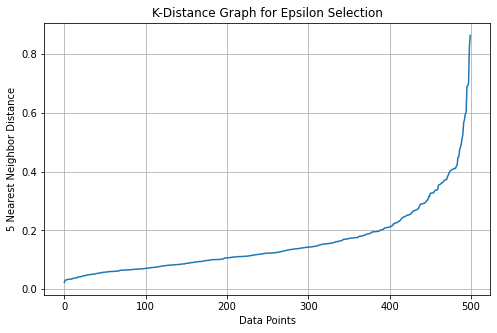

In [37]:
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(scaled_df.iloc[:, :-1])
distances, indices = neighbors_fit.kneighbors(scaled_df.iloc[:, :-1])

distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points")
plt.ylabel("5 Nearest Neighbor Distance")
plt.title("K-Distance Graph for Epsilon Selection")
plt.grid()
plt.show()

In [38]:
epsilon = 0.25

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
scaled_df['DBSCAN_Labels'] = dbscan.fit_predict(scaled_df.iloc[:, :-1])

print(scaled_df['DBSCAN_Labels'].value_counts())

 1    225
 0    112
 2    110
-1     46
 4      4
 3      3
Name: DBSCAN_Labels, dtype: int64


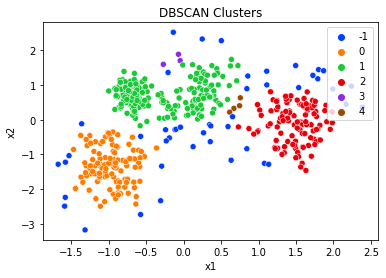

In [43]:
sns.scatterplot(
    data=scaled_df, 
    x=scaled_df.columns[0], 
    y=scaled_df.columns[1], 
    hue='DBSCAN_Labels', 
    palette='bright'
)
plt.title("DBSCAN Clusters")
plt.legend(loc='upper right')
plt.show()

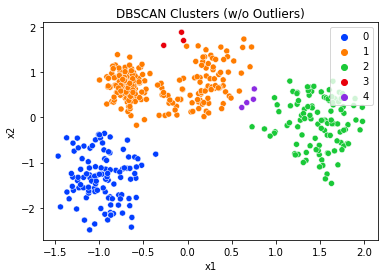

In [45]:
dbscan_df = scaled_df.copy()

dbscan_df = dbscan_df[dbscan_df['DBSCAN_Labels'] != -1]

# without outliers
sns.scatterplot(
    data=dbscan_df, 
    x=dbscan_df.columns[0], 
    y=dbscan_df.columns[1], 
    hue='DBSCAN_Labels', 
    palette='bright'
)
plt.title("DBSCAN Clusters (w/o Outliers)")
plt.legend(loc='upper right')
plt.show()

The graph with outliers has significant noise, and it's easier to interpret the graph without outliers, as the clusers are more defined. Since a lot of points are outliers, the epsilon might be too small and have to be increased to include more points in the clusters.

# Part 5: Model Evaluation

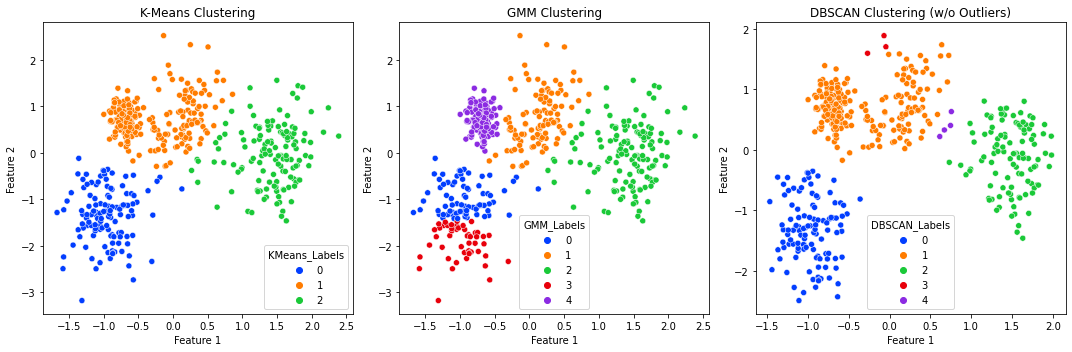

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

# K-Means plot
sns.scatterplot(
    x=scaled_df[scaled_df.columns[0]], 
    y=scaled_df[scaled_df.columns[1]], 
    hue=scaled_df['KMeans_Labels'], 
    palette="bright", 
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Gaussian Mixture Model plot
sns.scatterplot(
    x=scaled_df[scaled_df.columns[0]], 
    y=scaled_df[scaled_df.columns[1]], 
    hue=scaled_df['GMM_Labels'], 
    palette="bright", 
    ax=axes[1]
)
axes[1].set_title("GMM Clustering")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

# DBSCAN plot
sns.scatterplot(
    x=dbscan_df[dbscan_df.columns[0]], 
    y=dbscan_df[dbscan_df.columns[1]], 
    hue=dbscan_df['DBSCAN_Labels'], 
    palette="bright", 
    ax=axes[2]
)
axes[2].set_title("DBSCAN Clustering (w/o Outliers)")
axes[2].set_xlabel("Feature 1")
axes[2].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

In [47]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette Scores
kmeans_silhouette = silhouette_score(scaled_df.iloc[:, :-3], scaled_df['KMeans_Labels'])
gmm_silhouette = silhouette_score(scaled_df.iloc[:, :-3], scaled_df['GMM_Labels'])
dbscan_silhouette = silhouette_score(
    dbscan_df.iloc[:, :-1], 
    dbscan_df['DBSCAN_Labels']
)

# Davies-Bouldin Scores
kmeans_db = davies_bouldin_score(scaled_df.iloc[:, :-3], scaled_df['KMeans_Labels'])
gmm_db = davies_bouldin_score(scaled_df.iloc[:, :-3], scaled_df['GMM_Labels'])
dbscan_db = davies_bouldin_score(
    dbscan_df.iloc[:, :-1], 
    dbscan_df['DBSCAN_Labels']
)

# Print results
print(f"K-Means: Silhouette Score = {kmeans_silhouette}, Davies-Bouldin Score = {kmeans_db}")
print(f"GMM: Silhouette Score = {gmm_silhouette}, Davies-Bouldin Score = {gmm_db}")
print(f"DBSCAN: Silhouette Score = {dbscan_silhouette}, Davies-Bouldin Score = {dbscan_db}")


K-Means: Silhouette Score = 0.5718560352460762, Davies-Bouldin Score = 0.605148539236355
GMM: Silhouette Score = 0.4397005487341993, Davies-Bouldin Score = 0.8781963980104261
DBSCAN: Silhouette Score = 0.20048611100701072, Davies-Bouldin Score = 1.013377207926729
